In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import pandas as pd

# make sure the 'code' dir is on your path (change this):
codepath = '/user_data/mmhender/texturemodel/code/'
sys.path.insert(0,codepath)

from plotting import plot_utils, summary_plots, load_fits, pycortex_plot_utils
plot_utils.set_all_font_sizes(12)
from utils import roi_utils, default_paths, stats_utils, nsd_utils

#### Load model fits

In [3]:
subjects = np.arange(1,9)
n_subjects = len(subjects)

fitting_type = 'texture_pyramid_ridge_4ori_4sf_pcaHL_use_texture_pRFs'

out = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type, \
                                  n_from_end=0, verbose=False) \
       for ss in subjects]

# shuffled model fits, to compute significance of model fit each ROI.
fitting_type_shuffle = 'texture_pyramid_ridge_4ori_4sf_pcaHL_use_texture_pRFs_permutation_test'
out_shuff = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type_shuffle, \
                                  n_from_end=0, verbose=False) \
                                    for ss in subjects]

# bootstrap results, for significance of unique variance explained each feature set
fitting_type_boot = 'texture_pyramid_ridge_4ori_4sf_pcaHL_use_texture_pRFs_bootstrap_test_val'
out_boot = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type_boot, \
                                  n_from_end=0, verbose=False) \
                                    for ss in subjects]

#### Make ROI definitions

In [4]:
roi_def = roi_utils.multi_subject_roi_def(subjects, areas_include = ['V1','V2','V3','hV4', \
                                                      'OPA','PPA','RSC',\
                                                      'FFA','EBA'], use_kastner_areas=False, \
                                         remove_ret_overlap=True, remove_categ_overlap=True)
roi_names = roi_def.roi_names;
n_rois = len(roi_names)

#### Prepare to analyze variance partition results, set params

In [5]:
name1 = out[0]['partial_version_names'][1].split('just_')[1]
name2 = out[0]['partial_version_names'][2].split('just_')[1]

ve_names = ['shared', 'unique: ' + name1, 'unique: ' + name2]

gray_color = np.array([[0.6, 0.6, 0.6, 1]])

vis_color1 = np.array([[7,134,217,255]])/255
vis_color2 = np.array([[228,77,50,255]])/255

colors = np.concatenate([gray_color, vis_color1, vis_color2], axis=0)

#### Process results of permutation test, compute p-values
(this tests whether whole model is above chance)

In [6]:
pvals_singlevoxels_modelsig = [[] for si in range(n_subjects)]

for si in range(n_subjects):

    # stats for single voxels
    r2_real = out[si]['val_r2']
    r2_shuff = out_shuff[si]['val_r2']

    # for how many of the shuffle iterations did shuffle-R2 exceed real-R2?
    p = np.mean(r2_real[:,0,None]<=r2_shuff[:,0,:], axis=1)
    _,pvals_fdr = stats_utils.fdr_keepshape(p, alpha=0.01, \
                                                   method='poscorr')
    
    pvals_singlevoxels_modelsig[si] = pvals_fdr
    

#### Process results of bootstrap test for unique variance, compute p-values
(this tests whether unique/shared var are significant)

In [7]:
pvals_singlevoxels_uniquesig = [[] for si in range(n_subjects)]

pvals_rois_uniquesig = np.zeros((n_subjects, n_rois, 2))
pvals_rois_diff = np.zeros((n_subjects, n_rois))
signs_rois_diff = np.zeros((n_subjects, n_rois))

propvox_uniquesig = np.zeros((n_subjects, n_rois+1, 2))

n_iter = out_boot[si]['val_r2'].shape[2] # number of bootstrapping iterations
unique_boot_mean =  np.zeros((n_subjects, n_rois, 2, n_iter))
shared_boot_mean =  np.zeros((n_subjects, n_rois, 1, n_iter))

for si in range(n_subjects):
    
    # identify all the voxels where the model fit was above chance, and noise ceiling was good
    model_sig = pvals_singlevoxels_modelsig[si]<0.01
    abv_thresh = summary_plots.get_noise_ceiling(out[si])>0.01

    r2_boot = out_boot[si]['val_r2']
    # [unique low, unique high]
    unique_boot = r2_boot[:,0:1,:] - r2_boot[:,[2,1],:]
    # shared variance between low and high
    shared_boot = np.sum(r2_boot[:,1:3,:], axis=1) - r2_boot[:,0,:]
            
    pvals_fdr_all  = np.zeros((r2_boot.shape[0],2))
    
    # compute bootstrap means for unique variance
    for ff in range(2):

        # for how many of the bootstrap iterations was unique <= 0?
        p = np.mean(unique_boot[:,ff,:]<=0, axis=1)
        # fdr correct across voxels
        _,pvals_fdr = stats_utils.fdr_keepshape(p, alpha=0.01, \
                                                       method='poscorr')
        pvals_fdr_all[:,ff] = pvals_fdr
        
        # how many voxels were significant (all areas)
        propvox_uniquesig[si,n_rois,ff] = np.mean(pvals_fdr[abv_thresh & model_sig]<0.01)
        
        for rr in range(n_rois):

            inds = roi_def.ss_roi_defs[si].get_indices(rr) & abv_thresh & model_sig
         
            # how many voxels were significant (this roi)
            propvox_uniquesig[si,rr,ff] = np.mean(pvals_fdr[inds]<0.01)
            
            # average the individual bootstrapped values across voxels, in this ROI
            roimean = np.mean(unique_boot[inds,ff,:], axis=0)
            
            unique_boot_mean[si,rr,ff,:] = roimean
                              
            # p value for this ROI 
            # for how many of the bootstrap iterations was unique <= 0?
            pvals_rois_uniquesig[si,rr,ff] = np.mean(roimean<=0)
            
            if ff==1:
                # figure out if there is a low versus high level difference
                # for this single subject and this ROI
                diff = unique_boot_mean[si,rr,1,:] - unique_boot_mean[si,rr,0,:]
                pvals_rois_diff[si,rr] = np.minimum(np.mean(diff<=0), np.mean(diff>=0))*2
                signs_rois_diff[si,rr] = np.mean(diff<=0)<0.5
            
            
    pvals_singlevoxels_uniquesig[si] = pvals_fdr_all
    
    # compute bootstrap means for shared variance
    for rr in range(n_rois):

        inds = roi_def.ss_roi_defs[si].get_indices(rr) & abv_thresh & model_sig

        # average the individual bootstrapped values across voxels, in this ROI
        roimean = np.mean(shared_boot[inds,:], axis=0)

        shared_boot_mean[si,rr,0,:] = roimean

#### Multiple comparison correction, for single-subject significance values
Use holm-bonferroni method to correct over ROIs, because there is a small number of comparisons

In [8]:
issig_rois_uniquesig_hb, thrs = stats_utils.holm_bonferroni(pvals_rois_uniquesig, q=0.01)
issig_rois_diff_hb, thrs = stats_utils.holm_bonferroni(pvals_rois_diff, q=0.01)

#### Compute stats at the subject-averaged level
Median and confidence intervals (these are CIs for the subject-averaged means)

In [9]:
unique_boot_avgsubs = np.mean(unique_boot_mean, axis=0)
lowci_unique, median_unique, highci_unique = np.percentile(unique_boot_avgsubs, [0.5, 50, 99.5], axis=2)

shared_boot_avgsubs = np.mean(shared_boot_mean, axis=0)
lowci_shared, median_shared, highci_shared = np.percentile(shared_boot_avgsubs, [0.5, 50, 99.5], axis=2)


#### Significance at the subject-averaged level
(all these values are significant)

In [10]:
pvals_rois_avgsubj = np.mean(unique_boot_avgsubs<=0, axis=2)
roi_sig_mask_unique, thrs = stats_utils.holm_bonferroni(pvals_rois_avgsubj, q=0.01)

pvals_shared_rois_avgsubj = np.mean(shared_boot_avgsubs<=0, axis=2)
roi_sig_mask_shared, thrs = stats_utils.holm_bonferroni(pvals_shared_rois_avgsubj, q=0.01)

#### Significance of difference between lower- and higher-level

In [12]:
boot_diffs = unique_boot_avgsubs[:,1,:] - unique_boot_avgsubs[:,0,:]
# two-tailed test for a difference 
pvals_diff_avgsubj = np.minimum(np.mean(boot_diffs<=0, axis=1), np.mean(boot_diffs>=0, axis=1))*2
# multiple comparison correction
roi_diff_mask, thrs = stats_utils.holm_bonferroni(pvals_diff_avgsubj, q=0.01)

#### Get individual subject means for shared/unique var (from regular data, not bootstrapped)

In [13]:
vals = np.zeros((n_subjects, n_rois, 3))

for si, ss in enumerate(subjects):
    
    val_r2 = out[si]['val_r2']    
    r2_full = val_r2[:,0]
    r2_ll = val_r2[:,1]
    r2_hl = val_r2[:,2]
    
    var_expl = np.array(stats_utils.get_shared_unique_var(r2_full, r2_ll, r2_hl, \
                                                          convert_to_prop=False)).T
    model_sig = pvals_singlevoxels_modelsig[si]<0.01
    abv_thresh = summary_plots.get_noise_ceiling(out[si])>0.01
    inds2use = model_sig & abv_thresh
   
    for ri in range(n_rois):
        
        inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & inds2use 
        vals[si,ri,:] = np.mean(var_expl[inds_this_roi,:], axis=0)
        

#### Plot CIs and bars

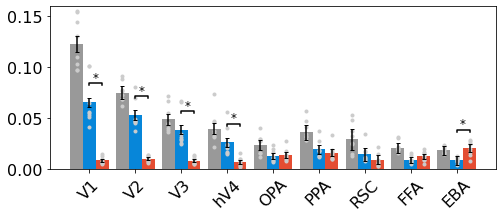

In [14]:
plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 16)
plt.figure(figsize=(8,3));
ax = plt.subplot(1,1,1)
shifts = [-0.28, 0, 0.28]

for ff in [0,1,2]:
    if ff==0:
        m = median_shared[:,0]
        l = lowci_shared[:,0]
        h = highci_shared[:,0]
    else:
        m = median_unique[:,ff-1]
        l = lowci_unique[:,ff-1]
        h = highci_unique[:,ff-1]
    
    plt.bar(np.arange(n_rois)+shifts[ff], \
                 m, color=colors[ff,:], width=0.28, zorder=-15)
    plt.errorbar(np.arange(n_rois)+shifts[ff], \
                 m, \
                 np.array([m-l,h-m]), \
                 linestyle='none',color='k',
                 capsize=2, 
                 # capsize=None,
                 # capsize=0, 
                 zorder=0)
       
    plt.plot(np.arange(n_rois)+shifts[ff], vals[:,:,ff].T, '.', color=[0.8, 0.8, 0.8], zorder=-10)

for rr in range(n_rois):  
    xx = rr;
    for ff in [0,1,2]:
        if ff==0:
            h = highci_shared[rr,0]
            is_sig = roi_sig_mask_shared[rr,0]
        else:
            h = highci_unique[rr,ff-1]
            is_sig = roi_sig_mask_unique[rr,ff-1]
        if is_sig:
            text_lab_ht = h+0.002
            # ax.annotate('*', xy=(xx+shifts[ff], text_lab_ht),
            #             zorder=20, color="k", ha="center", fontsize=12,)

    # annotate where low vs high is signicant 
    if roi_diff_mask[rr]:
        
        bracket_x1, bracket_x2 = shifts[1:3]
        brack_bottom = np.max(highci_unique[rr,:])+0.012
        brack_top = np.max(highci_unique[rr,:])+0.014
        plt.plot([xx + bracket_x1, xx + bracket_x1, xx + bracket_x2, xx + bracket_x2],
                [brack_bottom, brack_top, brack_top, brack_bottom],
                "-",color="k", zorder=20)
        text_lab_ht = np.max(highci_unique[rr,:])+0.016
        ax.annotate('*', xy=(xx + np.mean(shifts[1:3]), text_lab_ht),
                        zorder=20, color="k", ha="center", fontsize=12,)

    
plt.xticks(np.arange(n_rois), roi_names, rotation=45);

plt.ylim([0, 0.16])

plt.yticks([0, 0.05, 0.10, 0.15])
fn2save = os.path.join(default_paths.fig_path, 'texture_lowhigh_bars_CIs.pdf')
plt.savefig(fn2save)

#### Plot the proportion of individual voxels in each ROI that were above chance

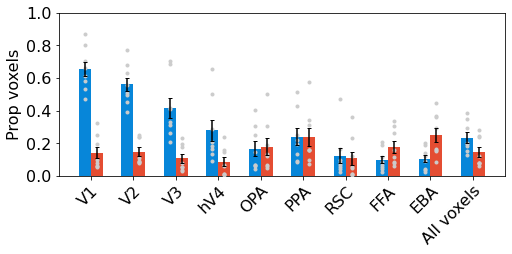

In [15]:
mean_vals = np.mean(propvox_uniquesig, axis=0)
sem_vals = np.std(propvox_uniquesig, axis=0) / np.sqrt(n_subjects)

plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 16)

fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, \
                                point_data = propvox_uniquesig, \
                           colors=colors[1:,:], space=0.22, \
                                err_capsize=2,
                xticklabels=roi_names+['All voxels'], ylabel='Prop voxels', \
                ylim=[0, 1.0], title='', horizontal_line_pos=None,\
                legend_labels=np.array(ve_names)[1:], \
                legend_overlaid=False, legend_separate=False, \
                fig_size=(8,3))


fn2save = os.path.join(default_paths.fig_path, 'texture_low_high_propsig.pdf')
plt.savefig(fn2save)

#### Making a table that summarizes the significance for single subjects

In [16]:
n_subs_each = np.sum(issig_rois_uniquesig_hb, axis=0).T
n_subs_diff = np.sum(issig_rois_diff_hb, axis=0, keepdims=True)
n_subs = np.concatenate([n_subs_each , n_subs_diff ], axis=0)
df = pd.DataFrame(n_subs, columns=roi_names, index=[name1, name2, 'sig diff'])
fn2save = os.path.join(default_paths.fig_path, 'nsubj_sig_lowhigh.csv')
print(fn2save)
df.to_csv(fn2save)
df

/user_data/mmhender/texturemodel/figures/nsubj_sig_lowhigh.csv


,V1,V2,V3,hV4,OPA,PPA,RSC,FFA,EBA
lower-level,8,8,8,8,6,8,2,5,4
higher-level,8,8,7,5,8,8,3,7,8
sig diff,8,8,8,7,0,1,0,0,4


#### Use PyCortex to make surface plots
plotting sqrt(unique var) here, because it is easier to see patterns

Note: this code will plot unique variance for low/high level separately.
To make the 2D plots that we showed, you can drag the high-level unique variance onto the low-level unique variance in the webviewer menu.


In [15]:
import cortex

volumes = {}

for si, ss in enumerate(subjects):

    names = []
    maps = []
    cmaps = []
    mins = []
    maxes = []
    
    val_r2 = out[si]['val_r2']    
    r2_full = val_r2[:,0]
    r2_ll = val_r2[:,1]
    r2_hl = val_r2[:,2]
    
    var_expl = np.array(stats_utils.get_shared_unique_var(r2_full, r2_ll, r2_hl, \
                                                          convert_to_prop=False)).T

    names += ['S%d: %s (sqrt var expl)'%(ss, name) for name in ve_names[1:]]
    for ve in [1,2]:
        vals = var_expl[:,ve]
        # going to plot sqrt of the variance explained here.
        # to avoid getting nans, take square root of the absolute value,
        # but keep the sign as it was originally.
        sqrt_vals = np.sign(vals) * np.sqrt(np.abs(vals))
        maps += [sqrt_vals]
           
    cmaps += ['Blues','Reds']
    mins += [0 for ve in range(2)]
    maxes += [0.30 for ve in range(2)]

    model_sig = pvals_singlevoxels_modelsig[si]<0.01
    abv_thresh = summary_plots.get_noise_ceiling(out[si])>0.01

    vox2plot = model_sig & abv_thresh

    voxel_mask = out[si]['voxel_mask']
    nii_shape = out[si]['brain_nii_shape']
    mask_3d = np.reshape(voxel_mask, nii_shape, order='C')

    vol_ss = pycortex_plot_utils.maps_to_volumes(ss, maps, names, \
                         cmaps=cmaps, mins=mins, maxes=maxes, \
                         voxel_mask=voxel_mask, nii_shape=nii_shape, mask_3d=mask_3d, \
                         vox2plot=vox2plot)

    volumes.update(vol_ss)
    
    vol_2d = cortex.Volume2D(dim1 = vol_ss[list(vol_ss.keys())[0]], \
                      dim2 = vol_ss[list(vol_ss.keys())[1]], cmap = 'PU_RdBu_covar_alpha')

    volumes.update({'S%d: Higher-level vs. lower-level'%ss: vol_2d})

#### Make the static webviewer html

In [18]:
import cortex
save_html_name = os.path.join(default_paths.fig_path, 'Variance_partition_low_vs_high.html')
title = 'Variance partition, lower-level vs. higher-level features'
viewer = cortex.webgl.make_static(outpath= save_html_name, \
                            data = volumes, 
                            recache = False,
                            title = title)


Stopping server


#### Make the dynamically served webviewer

In [16]:
viewer = pycortex_plot_utils.plot_with_overlays(volumes, title='Texture model summary', \
                                                port = 44443, \
                                                labels_on=True, recache=False, \
                                                overlay_type = None)

using overlays from /user_data/mmhender/pycortex_db/subj01/None.svg
navigate browser to: 127.0.0.1:44443
Started server on port 44443


#### Set view and save images of flatmaps

In [24]:
# load pre-made view params from a json file
# (json files are in your pycortex database folder, under subj01/views/)
# viewname='bottom'
# viewname = 'left-tilt'
# viewname='right-tilt'
viewname = 'flat'
viewer.get_view('subj01',viewname)

# to make the view:
# viewer.save_view('subj01','flat1',True)

In [25]:
ss=1;
fn2save = os.path.join(default_paths.fig_path, \
                       'S%02d_texture_low_high_%s_raw.png'%(ss,viewname))
print('saving to %s'%fn2save)
viewer.getImage(fn2save, \
                size=(3000,3000))

saving to /user_data/mmhender/texturemodel/figures/S01_texture_low_high_flat_raw.png


[{}]

In [26]:
# cropping the images
subject_bboxes = {'subj01':[200,200,2800,2800]}

In [27]:
import PIL
ss=1;

for viewname in ['left-tilt','right-tilt','bottom']:
# for viewname in ['left','right','bottom','top', 'left-tilt','right-tilt','bottom-tilt']:
    bbox = subject_bboxes['subj%02d'%ss]
    fn2save = os.path.join(default_paths.fig_path, \
                           'S%02d_texture_low_high_%s_raw.png'%(ss,viewname))
    fn2save_cropped = os.path.join(default_paths.fig_path, \
                                   'S%02d_texture_low_high_%s_cropped.png'%(ss,viewname))
    im = PIL.Image.open(fn2save)
    print(im.size[0])
    if im.size[0]==3000:
        pycortex_plot_utils.crop_image(fn2save, fn2save_cropped, bbox_new=bbox)

3000
3000
3000


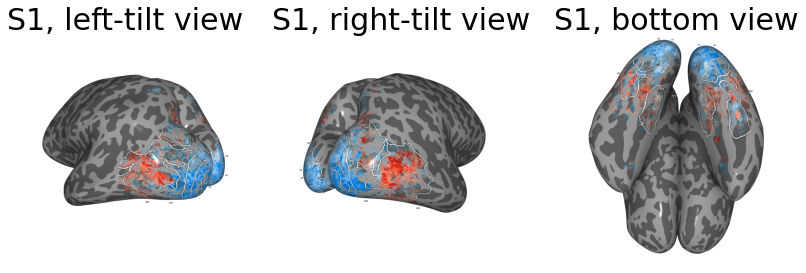

In [28]:
plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 30)

plt.figure(figsize=(14,7))

ss=1;

for vv, viewname in enumerate(['left-tilt','right-tilt','bottom']):
    
    fn2save_cropped = os.path.join(default_paths.fig_path, \
                                   'S%02d_texture_low_high_%s_cropped.png'%(ss,viewname))
    im = PIL.Image.open(fn2save_cropped)

    plt.subplot(1,3,vv+1);
    plt.imshow(im)
    plt.title('S%d, %s view'%(ss, viewname))
    # plt.axvline(im.size[0]/2,color='k')
    # plt.axhline(im.size[1]/2,color='k')
    plt.axis('off')
#     
fn2save = os.path.join(default_paths.fig_path, 'texture_low_high_views_S%d.pdf'%ss)
plt.savefig(fn2save,dpi=1000)

In [29]:
# cropping the images
subject_bboxes = {'subj01':[620,900,2220,2500], 'subj02':[620,900,2220,2500], \
                  'subj03': [620,800,2220,2400], 'subj04': [620,750,2220,2350], \
                  'subj05': [620,800,2220,2400], 'subj06': [620,1050,2220,2650], \
                  'subj07': [620,800,2220,2400], 'subj08': [620,900,2220,2500]}

In [30]:
import PIL
viewname='flat'
for ss in [1]:
# for ss in subjects:
    bbox = subject_bboxes['subj%02d'%ss]
    fn2save = os.path.join(default_paths.fig_path, \
                           'S%02d_texture_low_high_%s_raw.png'%(ss,viewname))
    fn2save_cropped = os.path.join(default_paths.fig_path, \
                                   'S%02d_texture_low_high_%s_cropped.png'%(ss,viewname))
    im = PIL.Image.open(fn2save)
    print(im.size[0])
    if im.size[0]==3000:
        pycortex_plot_utils.crop_image(fn2save, fn2save_cropped, bbox_new=bbox)

3000


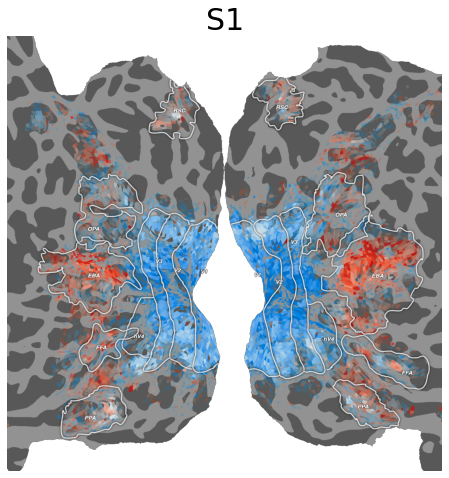

Stopping server


In [31]:
plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 30)

plt.figure(figsize=(8,8))

for ss in [1]:
    
    fn2save_cropped = os.path.join(default_paths.fig_path, \
                                   'S%02d_texture_low_high_%s_cropped.png'%(ss,viewname))
    im = PIL.Image.open(fn2save_cropped)

    plt.imshow(im)
    plt.title('S%d'%ss)
    # plt.axvline(im.size[0]/2,color='k')
    # plt.axhline(im.size[1]/2,color='k')
    plt.axis('off')
    
fn2save = os.path.join(default_paths.fig_path, 'texture_low_high_flat.pdf')
plt.savefig(fn2save,dpi=1000)